<a href="https://colab.research.google.com/github/Sushmitha-Katti/EVA-4/blob/master/S11_V4(Reduce_overfitting_by_weight_decay).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install Albumentation and Apex Package**

In [2]:
!pip install --no-cache-dir git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"


  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-41r0dxn2
Albumentation library is successfully installed!


## **Mount Drive and Unzip data**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%reload_ext autoreload
%autoreload 2

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
folder = '/content/gdrive/My Drive/API'
sys.path.append(folder)
folder = "/content/gdrive/My Drive/API/Models"
sys.path.append(folder)

## **Import required modules**

In [0]:

import torch
import train_test_loader
import show_images
from ResnetModel import ResNet18 
import train_test
import evaluate
from Albumentationtransform import AlbumentationTransforms
from GradCam import GradCAM,visualize_cam



## **Abumentation Transforms**

In [0]:
import albumentations as A
import cv2
channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform = AlbumentationTransforms([                                      
                                      A.PadIfNeeded(min_height=36, min_width=36, border_mode = cv2.BORDER_REFLECT, always_apply=True,),
                                      A.RandomCrop(height=32, width=32, always_apply=True),
                                      A.HorizontalFlip(p = 0.7),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=0.7) 
                                       ])
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])


## **Load Train Test Data**

In [7]:
classes, trainloader, testloader = train_test_loader.load(train_transform,test_transform,batch_size=512)

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## **Some training data**

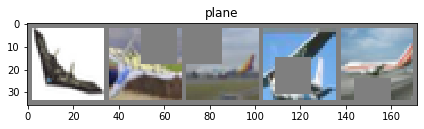

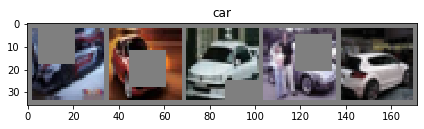

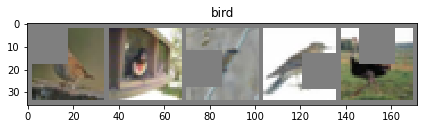

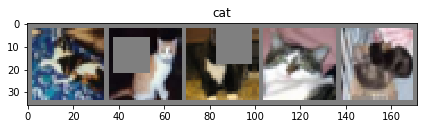

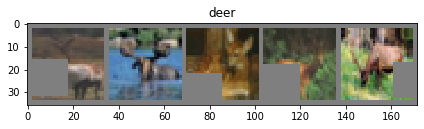

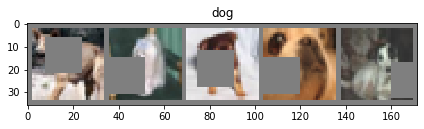

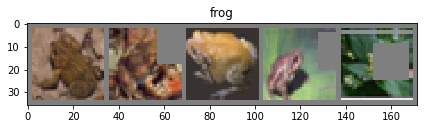

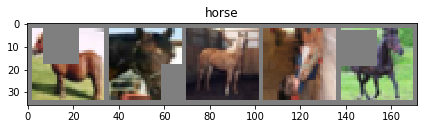

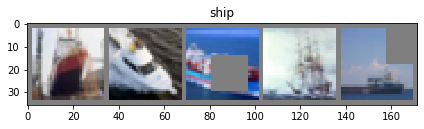

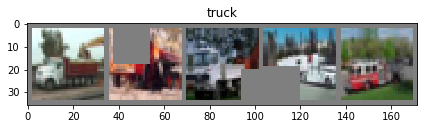

In [8]:
show_images.show_train_data(trainloader, classes)

## **Print Model Summary**

In [0]:
# uses this new ResNet Architecture for Cifar10:
# PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]
# Layer1 -
# X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]
# R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k] (Conv-BN-ReLU-Conv-BN-ReLU)
# Add(X, R1)
# Layer 2 -
# Conv 3x3 [256k]
# MaxPooling2D
# BN
# ReLU
# Layer 3 -
# X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]
# R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]
# Add(X, R2)
# MaxPooling with Kernel Size 4
# FC Layer 
# SoftMax


import torch.nn as nn
import torch.nn.functional as F

# ********************************************S11 MODEL***************************************************************
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.preplayer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, bias=False), 
            nn.BatchNorm2d(64),
            nn.ReLU(),  
            )
         #Layer1 -
# X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]
# R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k] (Conv-BN-ReLU-Conv-BN-ReLU)
# Add(X, R1)
        self.x1 = nn.Sequential(

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), 
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            )
        self.R1 = nn.Sequential(

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            )
        
         #Layer 2 -
# Conv 3x3 [256k]
# MaxPooling2D
# BN
# ReLU
        self.layer2 = nn.Sequential(

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False), 
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        
            )
        
#         Layer 3 -
# X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]
# R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]
# Add(X, R2)
        self.x2 = nn.Sequential(

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1, bias=False), 
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        
            )

        self.R2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False), 
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            )

        
        self.pool = nn.MaxPool2d(4, 4)

        self.fc = nn.Linear(in_features = 512, out_features = 10, bias=False)

      


    def forward(self, x):

        preplayer = self.preplayer(x) # i/p= 32 o/p=32 Rf = 6
        x1 = self.x1(preplayer)
        R1 = self.R1(x1)
        layer1 = x1+R1
        layer2 = self.layer2(layer1)
        x2 = self.x2(layer2)
        R2 = self.R2(x2)
        layer3 = R2+x2
        maxpool = self.pool(layer3)
        
       #print(maxpool.shape)
        
        # fc = self.fc(x)
       
        #print(fc.shape)
        #print(maxpool.shape)
        x = maxpool.view(maxpool.size(0),-1)
        #print(x.shape)
        #print(x.shape)
        fc = self.fc(x)

        return F.log_softmax(fc.view(-1,10), dim=-1)
      





In [10]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

## **Extract the best LR**

## **Initialise Loss funtion, Optimizer, Schedular**

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay=0.0005 ) 
scheduler = OneCycleLR(optimizer, max_lr = 0.01, total_steps=None, epochs=24, steps_per_epoch=1, pct_start=0.2083, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =1)

## **Train the Model for 50 Epochs**

In [12]:
test_loss = []
test_acc = []
EPOCHS = 24
LR = []
best_acc = 0
for epoch in range(EPOCHS):
     print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     LR.append(optimizer.param_groups[0]['lr'])
     train_loss, train_acc = train_test.train(model, device, trainloader, optimizer, criterion, epoch)
     scheduler.step()
     test_loss , test_acc = train_test.test(model, device, criterion, testloader)
     
     if(test_acc[-1]>best_acc):
       print("accuracy increased, Saving model....")
       best_acc = test_acc[-1]
       torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss[-1],
            }, "/content/gdrive/My Drive/API/bestmodel.pt")
 

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.001


Loss=1.3682554960250854 Batch_id=390 Accuracy=47.56: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s]



Test set: Average loss: 0.0086, Accuracy: 6126/10000 (61.26%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 2 LR: 0.0032504500900180037


Loss=0.7331576347351074 Batch_id=390 Accuracy=60.23: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 6586/10000 (65.86%)

accuracy increased, Saving model....
EPOCH: 3 LR: 0.005500900180036007


Loss=0.9650381207466125 Batch_id=390 Accuracy=66.89: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 6590/10000 (65.90%)

accuracy increased, Saving model....
EPOCH: 4 LR: 0.007751350270054012


Loss=0.8645321726799011 Batch_id=390 Accuracy=70.90: 100%|██████████| 391/391 [00:25<00:00, 15.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7643/10000 (76.43%)

accuracy increased, Saving model....
EPOCH: 5 LR: 0.009999621068586586


Loss=0.6004656553268433 Batch_id=390 Accuracy=73.64: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s]



Test set: Average loss: 0.0058, Accuracy: 7649/10000 (76.49%)

accuracy increased, Saving model....
EPOCH: 6 LR: 

  0%|          | 0/391 [00:00<?, ?it/s]

0.00952595680181887


Loss=0.7037020921707153 Batch_id=390 Accuracy=77.65: 100%|██████████| 391/391 [00:25<00:00, 15.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 8028/10000 (80.28%)

accuracy increased, Saving model....
EPOCH: 7 LR: 0.009052292535051156


Loss=0.32164594531059265 Batch_id=390 Accuracy=80.62: 100%|██████████| 391/391 [00:25<00:00, 15.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8488/10000 (84.88%)

accuracy increased, Saving model....
EPOCH: 8 LR: 0.00857862826828344


Loss=0.5373159646987915 Batch_id=390 Accuracy=82.85: 100%|██████████| 391/391 [00:25<00:00, 15.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8419/10000 (84.19%)

EPOCH: 9 LR: 0.008104964001515726


Loss=0.2749147415161133 Batch_id=390 Accuracy=84.65: 100%|██████████| 391/391 [00:25<00:00, 15.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8683/10000 (86.83%)

accuracy increased, Saving model....
EPOCH: 10 LR: 0.00763129973474801


Loss=0.47144556045532227 Batch_id=390 Accuracy=85.75: 100%|██████████| 391/391 [00:25<00:00, 15.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8737/10000 (87.37%)

accuracy increased, Saving model....
EPOCH: 11 LR: 0.007157635467980295


Loss=0.4375733435153961 Batch_id=390 Accuracy=86.90: 100%|██████████| 391/391 [00:25<00:00, 15.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8714/10000 (87.14%)

EPOCH: 12 LR: 0.00668397120121258


Loss=0.15979215502738953 Batch_id=390 Accuracy=88.27: 100%|██████████| 391/391 [00:24<00:00, 15.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8812/10000 (88.12%)

accuracy increased, Saving model....
EPOCH: 13 LR: 0.006210306934444866


Loss=0.23381824791431427 Batch_id=390 Accuracy=89.12: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8625/10000 (86.25%)

EPOCH: 14 LR: 0.00573664266767715


Loss=0.2865435481071472 Batch_id=390 Accuracy=90.21: 100%|██████████| 391/391 [00:24<00:00, 15.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8891/10000 (88.91%)

accuracy increased, Saving model....
EPOCH: 15 LR: 0.005262978400909435


Loss=0.24537293612957 Batch_id=390 Accuracy=90.98: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9016/10000 (90.16%)

accuracy increased, Saving model....
EPOCH: 16 LR: 0.00478931413414172


Loss=0.2581191658973694 Batch_id=390 Accuracy=91.84: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9043/10000 (90.43%)

accuracy increased, Saving model....
EPOCH: 17 LR: 0.004315649867374005


Loss=0.19705098867416382 Batch_id=390 Accuracy=92.42: 100%|██████████| 391/391 [00:25<00:00, 15.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8998/10000 (89.98%)

EPOCH: 18 LR: 0.0038419856006062895


Loss=0.2707814574241638 Batch_id=390 Accuracy=92.99: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9082/10000 (90.82%)

accuracy increased, Saving model....
EPOCH: 19 LR: 0.0033683213338385736


Loss=0.14225029945373535 Batch_id=390 Accuracy=93.86: 100%|██████████| 391/391 [00:25<00:00, 15.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9095/10000 (90.95%)

accuracy increased, Saving model....
EPOCH: 20 LR: 0.0028946570670708594


Loss=0.12295792996883392 Batch_id=390 Accuracy=94.27: 100%|██████████| 391/391 [00:25<00:00, 15.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9101/10000 (91.01%)

accuracy increased, Saving model....
EPOCH: 21 LR: 0.0024209928003031444


Loss=0.1943972110748291 Batch_id=390 Accuracy=94.72: 100%|██████████| 391/391 [00:24<00:00, 15.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9122/10000 (91.22%)

accuracy increased, Saving model....
EPOCH: 22 LR: 0.0019473285335354293


Loss=0.20011106133460999 Batch_id=390 Accuracy=95.18: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9146/10000 (91.46%)

accuracy increased, Saving model....
EPOCH: 23 LR: 0.0014736642667677134


Loss=0.07477949559688568 Batch_id=390 Accuracy=95.69: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9154/10000 (91.54%)

accuracy increased, Saving model....
EPOCH: 24 LR: 0.0009999999999999992


Loss=0.08434543758630753 Batch_id=390 Accuracy=96.24: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s]



Test set: Average loss: 0.0021, Accuracy: 9196/10000 (91.96%)

accuracy increased, Saving model....


## **Load the Best Accuracy Model**

In [14]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9 ,weight_decay = 0.0005)
checkpoint = torch.load("/content/gdrive/My Drive/API/bestmodel.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

Loaded the best model


## **Evaluate the class wise accuracy**

In [15]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 92 %
Accuracy of   car : 97 %
Accuracy of  bird : 88 %
Accuracy of   cat : 82 %
Accuracy of  deer : 93 %
Accuracy of   dog : 86 %
Accuracy of  frog : 94 %
Accuracy of horse : 94 %
Accuracy of  ship : 96 %
Accuracy of truck : 94 %


## **Plot accurary change in test and train**

In [16]:
scheduler.get_lr()

[0.000526335733232285]

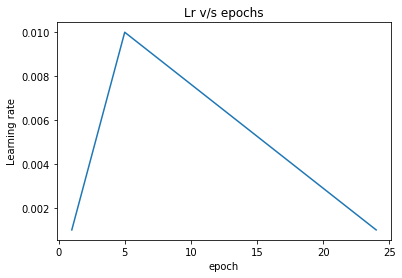

In [28]:
import matplotlib.pyplot as plt
epochs = []
for i in range(24):
  epochs.append(i+1)

plt.plot(epochs,LR)
plt.ylabel('Learning rate')
plt.xlabel("epoch")
plt.title("Lr v/s epochs")
plt.show()


## **Extract 25 misclassified_images**

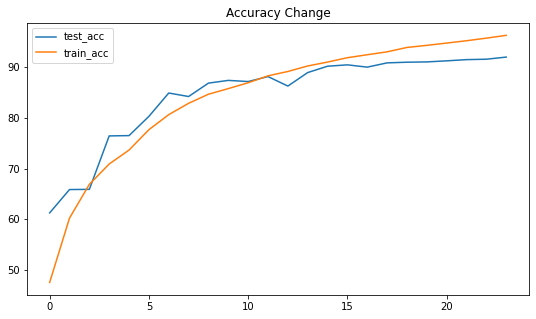

In [26]:
curves = [(test_acc,"test_acc"),(train_acc,"train_acc")]
evaluate.plot_curve(curves,"Accuracy Change",Figsize = (9,5))


## **GradCam View of misclassified images(for all 4 layers)**

In [32]:
model.eval()

Net(
  (preplayer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (x1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (R1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(128, 256, kernel_

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


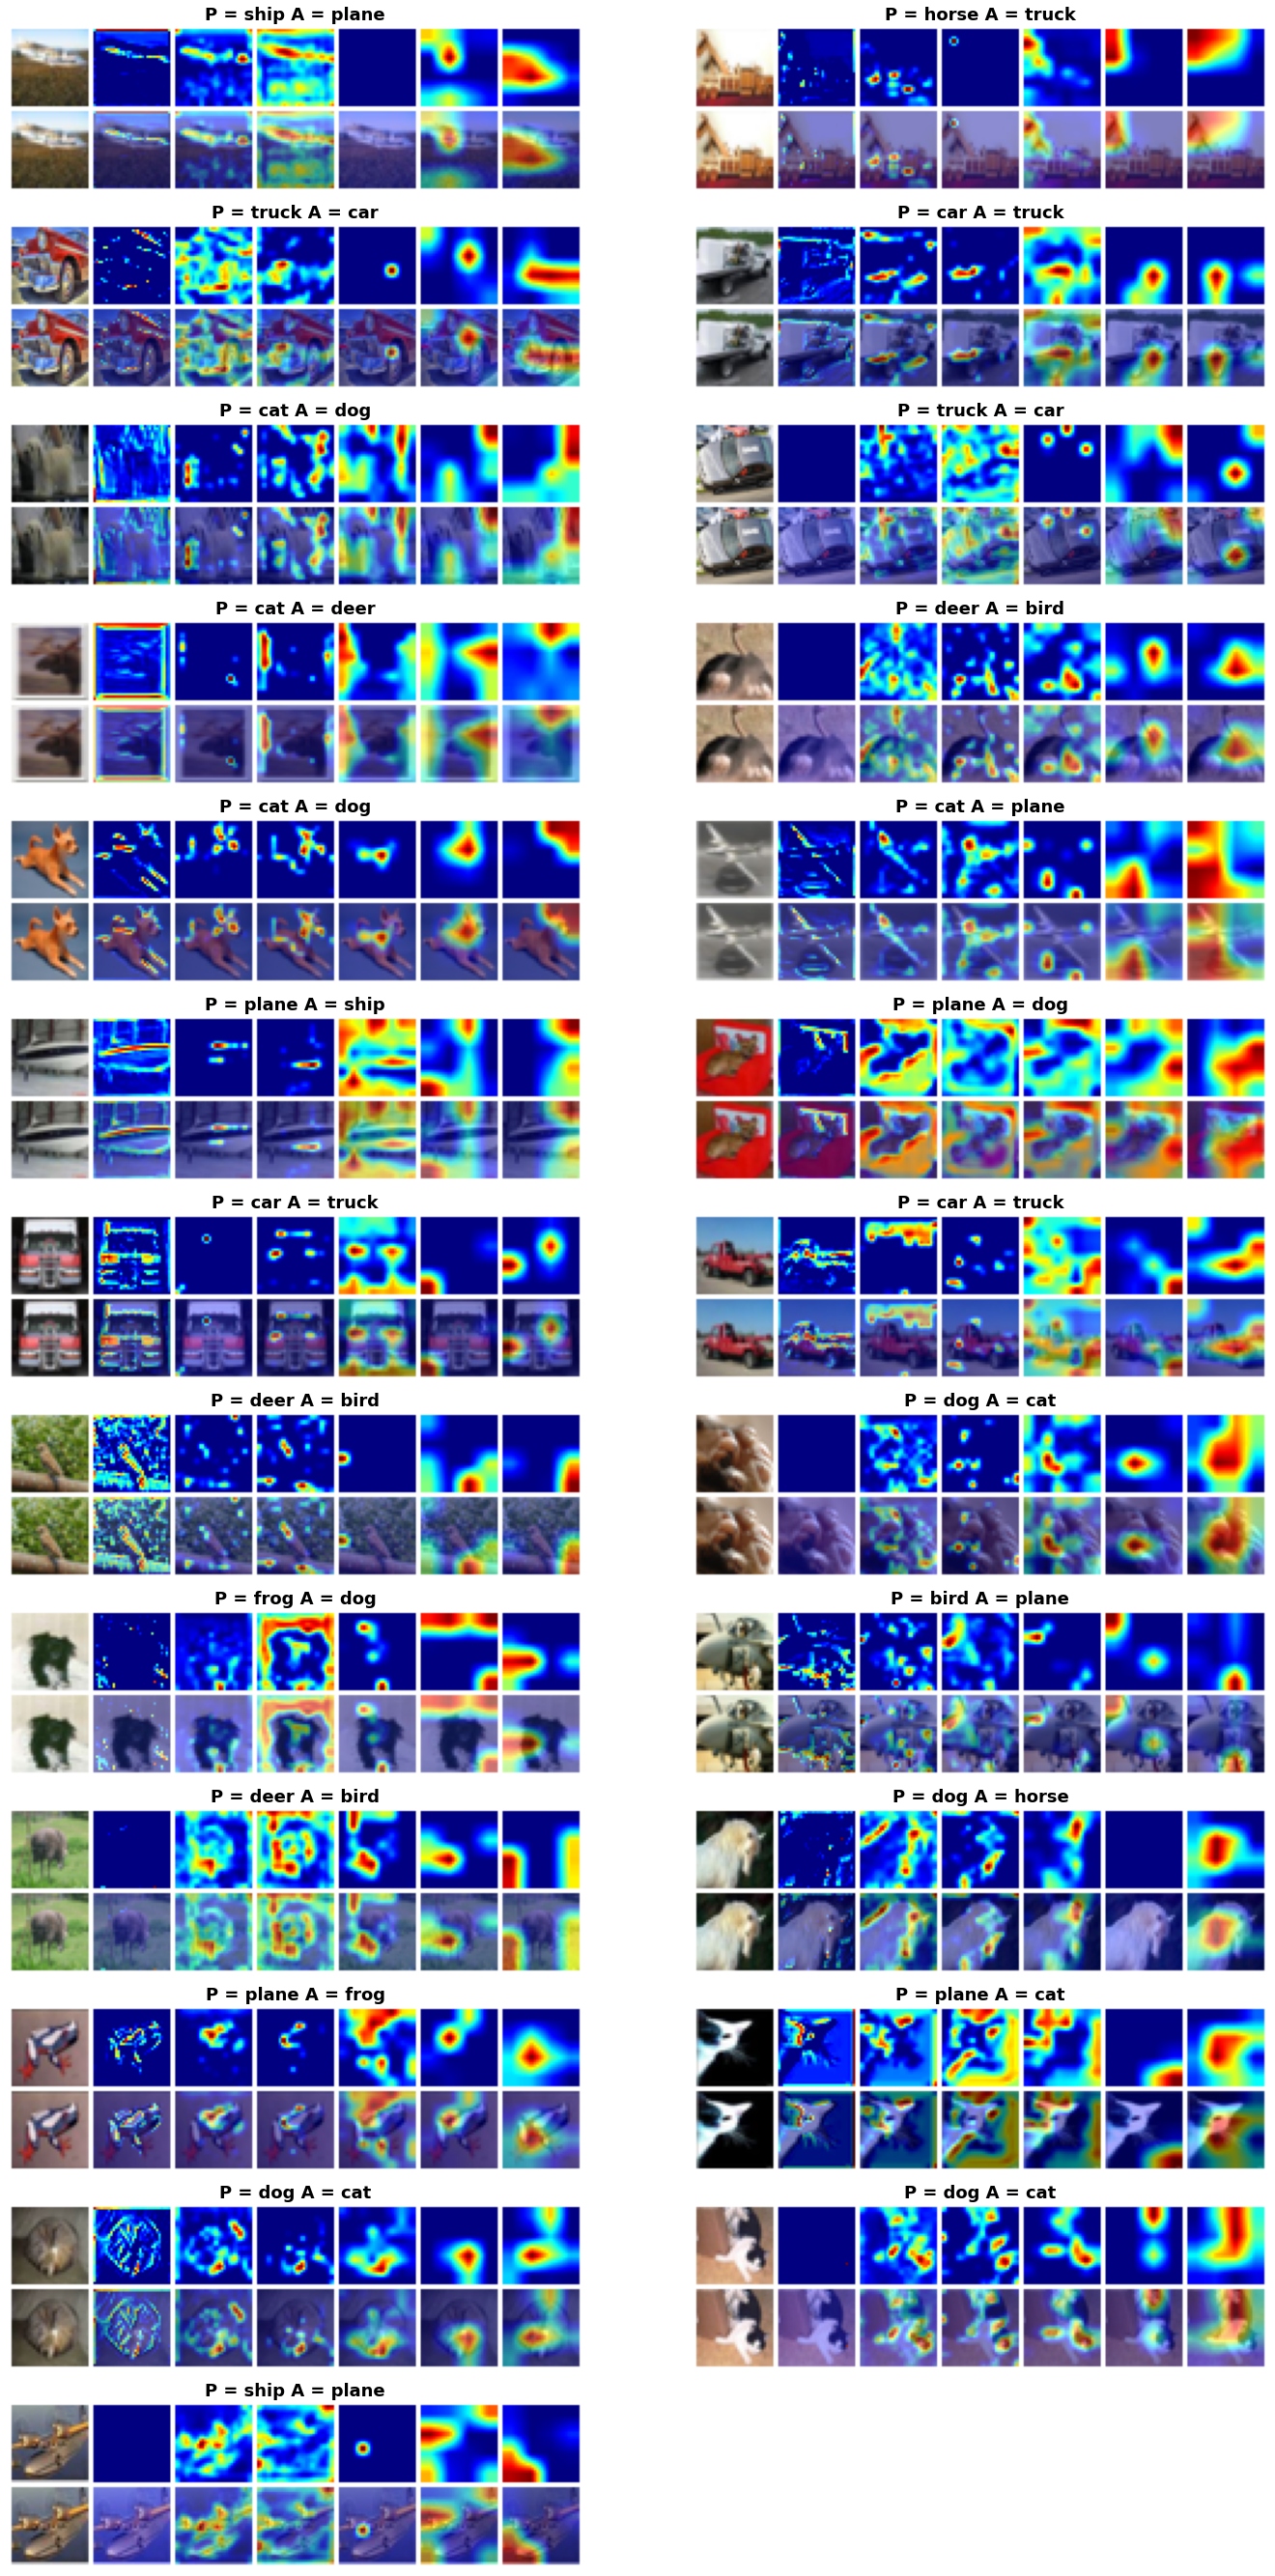

In [22]:

from GradCam import GradCamView
layers = [model.preplayer, model.x1,model.R1,model.layer2,model.x2,model.R2]
miscalssified_images = evaluate.show_misclassified_images(model, device, testloader, classes)
GradCamView(miscalssified_images,model,classes,layers,Figsize = (20,40),subplotx1 = 14, subplotx2 = 2)
